In this Homework, you will make a question answering bot using using Transformers.

TODO:
1. Tokenize the data and create a vocabulary using [sentencepiece](https://github.com/google/sentencepiece/blob/master/python/README.md). Set `vocab_size=1000, pad_id=0, unk_id=1, bos_id=2, eos_id=3`. After making the tokenization model encode your data and don't forget to add <sos\> and <eos\>.
2. Pad your source and target data.
3. Split the data into 80:20 train and test set.
4. Create and train your own encorder-decoder transformer architecture using pytorch/tensorflow.
6. Evaluate your models on test data and calculate the [bleu score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).
7. Show some example questions, true answers and generated answers from the test data.
8. Ask it some questions of your own and show how how it answers.


In [186]:
!wget https://qnamakerstore.blob.core.windows.net/qnamakerdata/editorial/english/qna_chitchat_professional.tsv

--2024-08-02 10:20:46--  https://qnamakerstore.blob.core.windows.net/qnamakerdata/editorial/english/qna_chitchat_professional.tsv
Resolving qnamakerstore.blob.core.windows.net (qnamakerstore.blob.core.windows.net)... 20.60.81.165
Connecting to qnamakerstore.blob.core.windows.net (qnamakerstore.blob.core.windows.net)|20.60.81.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 981694 (959K) [text/plain]
Saving to: ‘qna_chitchat_professional.tsv.4’

qna_chitchat_profes 100%[===================>] 958.69K  4.73MB/s    in 0.2s    

2024-08-02 10:20:46 (4.73 MB/s) - ‘qna_chitchat_professional.tsv.4’ saved [981694/981694]



In [187]:
import pandas as pd
pd.read_csv("qna_chitchat_professional.tsv", sep="\t")[["Question", "Answer"]].to_csv("qna_chitchat_professional.tsv", index=False, sep="\t")

In [188]:
from IPython.display import clear_output, display
import os
import math
import random
import torch


from nltk.translate.bleu_score import corpus_bleu
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.datasets import CocoCaptions
import matplotlib.pyplot as plt
from tqdm import tqdm
import sentencepiece
import csv
from sklearn.model_selection import train_test_split
clear_output()


## 1-Tokenization
Tokenize the data and create a vocabulary using sentencepiece. Set vocab_size=1000, pad_id=0, unk_id=1, bos_id=2, eos_id=3. After making the tokenization model encode your data and don't forget to add <sos> and <eos>.

In [189]:
sentencepiece.SentencePieceTrainer.train(
  input="qna_chitchat_professional.tsv",
  model_prefix="myspm_model",
  vocab_size=1000,
  pad_id=0,
  unk_id=1,
  bos_id=2,
  eos_id=3,
  pad_piece='<pad>',
  unk_piece='<unk>',
  bos_piece='<sos>',
  eos_piece='<eos>'
)

In [190]:
spm = sentencepiece.SentencePieceProcessor(model_file="myspm_model.model")
vocab = [spm.id_to_piece(i) for i in range(spm.get_piece_size())]
print("Vocabulary sample:")
print(vocab[:10])

Vocabulary sample:
['<pad>', '<unk>', '<sos>', '<eos>', '.', '▁I', "'", '▁you', 's', '▁to']


In [191]:
encoded_questions = []
encoded_answers = []

with open("qna_chitchat_professional.tsv", 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    next(reader)
    for row in reader:
        question = spm.encode_as_ids(row[0])
        answer = spm.encode_as_ids(row[1])
        question = [spm.bos_id()] + question + [spm.eos_id()]
        answer = [spm.bos_id()] + answer + [spm.eos_id()]
        encoded_questions.append(question)
        encoded_answers.append(answer)

print(encoded_questions[0])
print(encoded_answers[0])

[2, 40, 7, 63, 529, 12, 3]
[2, 5, 18, 6, 10, 17, 14, 290, 4, 3]


## 2-Padding
Pad your source and target data.

In [192]:
max_q_length = max(len(q) for q in encoded_questions)
max_a_length = max(len(a) for a in encoded_answers)
questions_lengths = [len(q) for q in encoded_questions]
padded_questions = [q + [spm.pad_id()] * (max_q_length - len(q)) for q in encoded_questions]
padded_answers = [a + [spm.pad_id()] * (max_a_length - len(a)) for a in encoded_answers]
print(max_q_length, max_a_length) # reasonable lengths
print(padded_questions[0])
print(questions_lengths[0])
print(padded_answers[0])

26 46
[2, 40, 7, 63, 529, 12, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7
[2, 5, 18, 6, 10, 17, 14, 290, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 3-Data split
Split the data into 80:20 train and test set.


In [193]:
questions_tensor = torch.tensor(padded_questions, dtype=torch.long)
questions_lengths_tensor = torch.tensor(questions_lengths, dtype=torch.long)
answers_tensor = torch.tensor(padded_answers, dtype=torch.long)
# print(questions_lengths_tensor)
train_val_questions, test_questions, train_val_answers, test_answers, train_val_lengths, test_lengths = train_test_split(
    questions_tensor, answers_tensor, questions_lengths_tensor, test_size=0.2
)

train_questions, val_questions, train_answers, val_answers, train_lengths, val_lengths = train_test_split(
    train_val_questions, train_val_answers, train_val_lengths, test_size=0.1
)

class CustomDataset(Dataset):
    def __init__(self, questions, lengths, answers):
        self.questions = questions
        self.lengths = lengths
        self.answers = answers

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        # length = self.lengths[idx]
        answer = self.answers[idx]
        # question_mask = (question != spm.pad_id())

        # answer_pad_mask = (answer != spm.pad_id())
        # answer_mask = answer_pad_mask.unsqueeze(0)&self.causal_mask(answer.size(0))


        return question, answer

    @staticmethod
    def causal_mask(size):
        mask = torch.triu(torch.ones((size, size)), diagonal=1)
        return mask == 0

train_dataset = CustomDataset(train_questions, train_lengths, train_answers)
val_dataset = CustomDataset(val_questions, val_lengths, val_answers)
test_dataset = CustomDataset(test_questions, test_lengths, test_answers)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [194]:
len(train_dataloader.dataset), len(val_dataloader.dataset), len(test_dataloader.dataset)

(7050, 784, 1959)

In [195]:
train_dataset[0]

(tensor([  2,   5,   8, 212, 482,   9,  93,  81,  16,  12,   3,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 tensor([ 2,  5,  6, 11, 52, 53,  8, 39,  9, 93,  4,  3,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]))

## 4-Model
4. Create and train your own encorder-decoder transformer architecture using pytorch/tensorflow.

### Model Archeticture
<i>I am going to implement the components shown in this figure: </i>
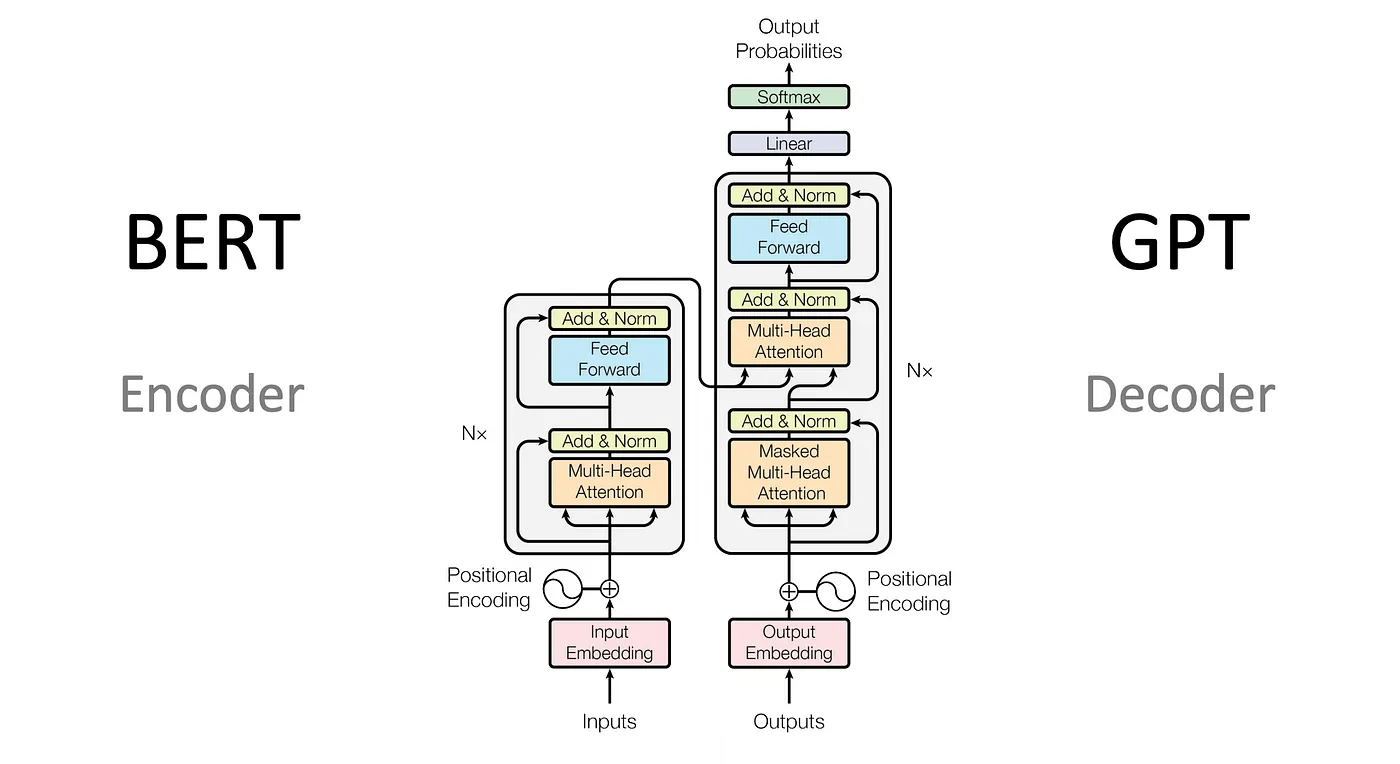

In [196]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :].expand(-1, x.size(1), -1)

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, feedforward_dim, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(embedding_dim, feedforward_dim)
        self.linear2 = nn.Linear(feedforward_dim, embedding_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))

class QuestionEncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, feedforward_dim, dropout=0.1):
        super(QuestionEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout)
        self.feed_forward = FeedForward(embedding_dim, feedforward_dim, dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, questions, questions_mask=None, questions_key_padding_mask=None):
        attn_output = self.self_attn(questions, questions, questions, attn_mask=questions_mask, key_padding_mask=questions_key_padding_mask)[0]
        questions = questions + self.dropout1(attn_output)
        questions = self.norm1(questions)
        ff_output = self.feed_forward(questions)
        questions = questions + self.dropout2(ff_output)
        questions = self.norm2(questions)
        return questions

class AnswerDecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, feedforward_dim, dropout=0.1):
        super(AnswerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout)
        self.cross_attention = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout)
        self.feed_forward = FeedForward(embedding_dim, feedforward_dim, dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.norm3 = nn.LayerNorm(embedding_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, answers, encoder_output, answers_mask=None, encoder_output_mask=None, answers_key_padding_mask=None, encoder_output_key_padding_mask=None):
        self_attn_output = self.self_attn(answers, answers, answers, attn_mask=answers_mask, key_padding_mask=answers_key_padding_mask)[0]
        answers = answers + self.dropout1(self_attn_output)
        answers = self.norm1(answers)
        # Q from here, K and V from encoder outputs
        cross_attention_output = self.cross_attention(answers, encoder_output, encoder_output, attn_mask=encoder_output_mask, key_padding_mask=encoder_output_key_padding_mask)[0]
        answers = answers + self.dropout2(cross_attention_output)
        answers = self.norm2(answers)
        ff_output = self.feed_forward(answers)
        answers = answers + self.dropout3(ff_output)
        answers = self.norm3(answers)
        return answers

class QuestionEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(QuestionEncoder, self).__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])

    def forward(self, questions, mask=None, questions_key_padding_mask=None):
        output = questions
        for layer in self.layers:
            output = layer(output, questions_mask=mask, questions_key_padding_mask=questions_key_padding_mask)
        return output

class AnswerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers):
        super(AnswerDecoder, self).__init__()
        self.layers = nn.ModuleList([decoder_layer for _ in range(num_layers)])

    def forward(self, answers, encoder_output, answers_mask=None, encoder_output_mask=None, answers_key_padding_mask=None, encoder_output_key_padding_mask=None):
        output = answers
        for layer in self.layers:
            output = layer(output, encoder_output, answers_mask=answers_mask, encoder_output_mask=encoder_output_mask,
                           answers_key_padding_mask=answers_key_padding_mask,
                           encoder_output_key_padding_mask=encoder_output_key_padding_mask)
        return output

class QATransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, feedforward_dim, max_seq_length, dropout=0.1):
        super(QATransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_seq_length)

        encoder_layer = QuestionEncoderLayer(embedding_dim, num_heads, feedforward_dim, dropout)
        self.encoder = QuestionEncoder(encoder_layer, num_layers)

        decoder_layer = AnswerDecoderLayer(embedding_dim, num_heads, feedforward_dim, dropout)
        self.decoder = AnswerDecoder(decoder_layer, num_layers)

        self.output_layer = nn.Linear(embedding_dim, vocab_size)

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, questions, answers, questions_key_padding_mask=None, answers_key_padding_mask=None):
        questions = self.embedding(questions).permute(1, 0, 2) * math.sqrt(self.embedding_dim)
        questions = self.pos_encoder(questions)

        answers = self.embedding(answers).permute(1, 0, 2) * math.sqrt(self.embedding_dim)
        answers = self.pos_encoder(answers)

        answers_mask = self.generate_square_subsequent_mask(answers.size(0)).to(answers.device)

        encoder_output = self.encoder(questions, questions_key_padding_mask=questions_key_padding_mask)
        output = self.decoder(answers, encoder_output, answers_mask=answers_mask, answers_key_padding_mask=answers_key_padding_mask,
                      encoder_output_key_padding_mask=questions_key_padding_mask)

        output = output.permute(1, 0, 2)
        return self.output_layer(output)

    def answer_question(self, questions, max_len=50, device='cuda'):
        self.eval()
        with torch.no_grad():
            questions = questions.unsqueeze(0).to(device)
            questions_mask = (questions == 0).to(device)

            questions_embedded = self.embedding(questions).permute(1, 0, 2) * math.sqrt(self.embedding_dim)
            questions_embedded = self.pos_encoder(questions_embedded)

            encoder_output = self.encoder(questions_embedded, questions_key_padding_mask=questions_mask)

            ys = torch.ones(1, 1).fill_(spm.bos_id()).type(torch.long).to(device)
            for i in range(max_len-1):
                answers_mask = self.generate_square_subsequent_mask(ys.size(1)).to(device)
                answers_embedded = self.embedding(ys).permute(1, 0, 2) * math.sqrt(self.embedding_dim)
                answers_embedded = self.pos_encoder(answers_embedded)

                out = self.decoder(answers_embedded, encoder_output,
                                   answers_mask=answers_mask,
                                   encoder_output_key_padding_mask=questions_mask)

                out = out.transpose(0, 1)

                prob = self.output_layer(out[:, -1])
                _, next_word = torch.max(prob, dim=1)
                next_word = next_word.item()

                ys = torch.cat([ys, torch.ones(1, 1).type_as(questions.data).fill_(next_word)], dim=1)
                if next_word == spm.eos_id():
                    break

            return ys

In [197]:
vocab_size = len(vocab)
embedding_dim = 512
num_heads = 1
feedforward_dim = 2048
num_layers = 6
dropout = 0.1
max_seq_length = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
question_answering_transformer = QATransformer(vocab_size, embedding_dim, num_heads, num_layers, feedforward_dim, max_seq_length, dropout).to(device)

### Sanity check

In [198]:
question = "What are you doing?"
question_answering_transformer.eval()
with torch.no_grad():
    encoded_question = spm.encode(question)
    src = torch.LongTensor(encoded_question).to(device)

    print(f"\nQuestion: {question}")
    output = question_answering_transformer.answer_question(src)

    answer = spm.decode(output[0].tolist())
    print(f"Answer: {answer}\n")
# print(spm.pad_id())


Question: What are you doing?
Answer: digital woman woman woman woman woman woman woman Bet Bet Bet Bet Bet Bet Bet Bet Bet Bet awesomeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibeibe



In [199]:
batch = next(iter(train_dataloader))
questions, answers = batch
questions, answers = questions.to(device), answers.to(device)
src_masks = (questions == 0)
tgt_masks = (answers[:, :-1] == 0)
print(questions.shape, src_masks.shape, answers.shape, tgt_masks.shape)

torch.Size([128, 26]) torch.Size([128, 26]) torch.Size([128, 46]) torch.Size([128, 45])


In [200]:
print(questions[0])
print(src_masks[0])
print(answers[0])
print(tgt_masks[0])

tensor([  2, 270,   7, 259,   9,  16,  12,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       device='cuda:0')
tensor([False, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True], device='cuda:0')
tensor([  2,   5,   6,  11, 233,   5,   6,  11,  24, 216, 213, 226, 153,   4,
          3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0], device='cuda:0')
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True

In [201]:
## sanity check
output = question_answering_transformer(questions, answers)
print(output.shape)

torch.Size([128, 46, 1000])


### Training loop

In [202]:
learning_rate = 1e-4
num_epochs = 15
optimizer = torch.optim.Adam(question_answering_transformer.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=spm.pad_id())
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-9)

In [203]:
train_losses = []
val_losses = []


for epoch in range(num_epochs):

    question_answering_transformer.train()
    total_loss = 0
    for batch in train_dataloader:
        questions, answers = batch
        questions, answers = questions.to(device), answers.to(device)

        questions_key_padding_mask = (questions == 0)
        answers_key_padding_mask = (answers[:, :-1] == 0)

        answers_mask = question_answering_transformer.generate_square_subsequent_mask(answers.size(1) - 1).to(device)
        answers_mask = answers_mask.masked_fill(answers_mask == float('-inf'), 0.0).masked_fill(answers_mask == 0, float('-inf'))


        optimizer.zero_grad()

        output = question_answering_transformer(questions, answers[:, :-1],
                       questions_key_padding_mask=questions_key_padding_mask,
                       answers_key_padding_mask=answers_key_padding_mask)

        loss = criterion(output.contiguous().view(-1, question_answering_transformer.embedding.num_embeddings), answers[:, 1:].contiguous().view(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_dataloader)

    question_answering_transformer.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            questions, answers = batch
            questions, answers = questions.to(device), answers.to(device)

            questions_key_padding_mask = (questions == 0)
            answers_key_padding_mask = (answers[:, :-1] == 0)

            answers_mask = question_answering_transformer.generate_square_subsequent_mask(answers.size(1) - 1).to(device)
            answers_mask = answers_mask.masked_fill(answers_mask == float('-inf'), 0.0).masked_fill(answers_mask == 0, float('-inf'))

            output = question_answering_transformer(questions, answers[:, :-1],
                       questions_key_padding_mask=questions_key_padding_mask,
                       answers_key_padding_mask=answers_key_padding_mask
                           )

            loss = criterion(output.contiguous().view(-1, question_answering_transformer.embedding.num_embeddings), answers[:, 1:].contiguous().view(-1))

            total_loss += loss.item()

    val_epoch_loss = total_loss / len(val_dataloader)

    train_losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)

    print(f"\nEpoch: {epoch+1}/{num_epochs} Training loss: {epoch_loss:.4f} \t Validation loss: {val_epoch_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



Epoch: 1/15 Training loss: 3.6127 	 Validation loss: 1.6504

Epoch: 2/15 Training loss: 1.1215 	 Validation loss: 0.7081

Epoch: 3/15 Training loss: 0.6135 	 Validation loss: 0.4710

Epoch: 4/15 Training loss: 0.4567 	 Validation loss: 0.3739

Epoch: 5/15 Training loss: 0.3694 	 Validation loss: 0.3022

Epoch: 6/15 Training loss: 0.2981 	 Validation loss: 0.2396

Epoch: 7/15 Training loss: 0.2358 	 Validation loss: 0.1933

Epoch: 8/15 Training loss: 0.1897 	 Validation loss: 0.1551

Epoch: 9/15 Training loss: 0.1500 	 Validation loss: 0.1364

Epoch: 10/15 Training loss: 0.1199 	 Validation loss: 0.1123

Epoch: 11/15 Training loss: 0.1000 	 Validation loss: 0.1029

Epoch: 12/15 Training loss: 0.0796 	 Validation loss: 0.0920

Epoch: 13/15 Training loss: 0.0677 	 Validation loss: 0.0843

Epoch: 14/15 Training loss: 0.0552 	 Validation loss: 0.0841

Epoch: 15/15 Training loss: 0.0479 	 Validation loss: 0.0873


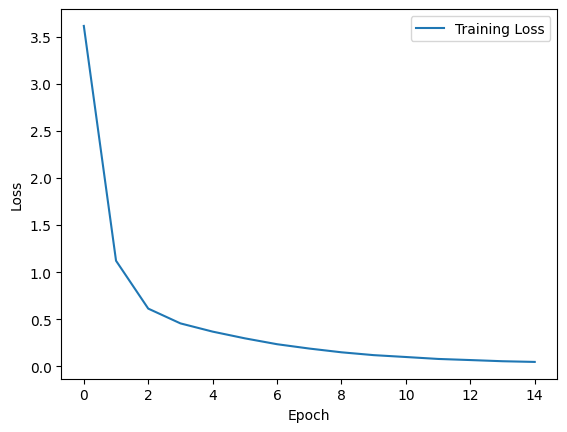

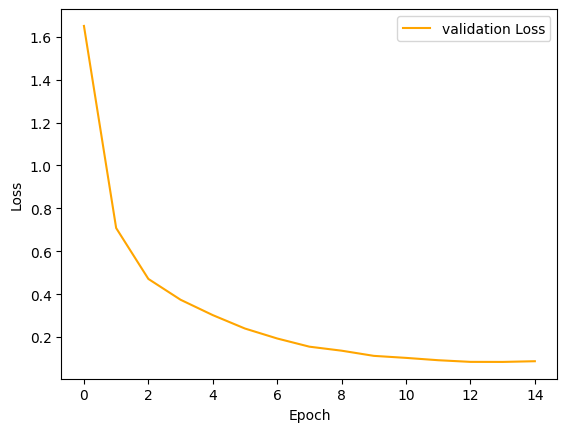

In [204]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(val_losses, label='validation Loss', color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5-Model Evaluation (BLEU score)
Evaluate your models on test data and calculate the [bleu score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).


In [210]:
question_answering_transformer.eval()
all_references = []
all_hypotheses = []

with torch.no_grad():
    for questions, answers in tqdm(test_dataloader):
        questions = questions.to(device)
        answers = answers.to(device)

        outputs = [question_answering_transformer.answer_question(question) for question in questions]
        for i in range(len(questions)):
            reference = spm.decode(answers[i].tolist()).split()
            hypothesis = spm.decode(outputs[i][0].tolist()).split()

            all_references.append([reference])
            all_hypotheses.append(hypothesis)

bleu_score = corpus_bleu(all_references, all_hypotheses)

print(f"\n {'==' * 10} BLEU Score: {bleu_score:.4f} {'==' * 10}")

100%|██████████| 16/16 [02:47<00:00, 10.44s/it]


 ==================== BLEU Score: 0.7666 ====================


## 6-Examples from test data
Show some example questions, true answers and generated answers from the test data.

In [206]:
count = 0
correct_count = 0
with torch.no_grad():
    for questions, answers in test_dataloader:
        if count >= 5:
            break
        count += 1

        questions = questions.to(device)
        answers = answers.to(device)

        output = question_answering_transformer.answer_question(questions[0])

        question = spm.decode(questions[0].tolist())
        true_answer = spm.decode(answers[0].tolist())
        generated_answer = spm.decode(output[0].tolist())

        is_correct = true_answer == generated_answer
        if is_correct:
            correct_count += 1

        print(f"""
        Question {count}:
        {question}
        Actual Answer: {true_answer}
        Generated Answer: {generated_answer}
        """)

print(f"\nNumber of correct examples: {correct_count}/{5}")



        Question 1:
        Do you know other chatbots?
        Actual Answer: I've heard of other bots, but I haven't met any.
        Generated Answer: I've heard of other bots, but I haven't met any.
        

        Question 2:
        I am currently travelling
        Actual Answer: Ok.
        Generated Answer: Okay.
        

        Question 3:
        Your answers are stupid
        Actual Answer: Sorry about that.
        Generated Answer: Sorry about that.
        

        Question 4:
        I want you to fall in love with me
        Actual Answer: Love isn't really in my skill set.
        Generated Answer: Love isn't really in my skill set.
        

        Question 5:
        Cortana is better
        Actual Answer: I try, but I don't always get it right.
        Generated Answer: I try, but I don't always get it right.
        

Number of correct examples: 4/5


## 7-Random Examples
Ask it some questions of your own and show how how it answers.

In [211]:
print("Enter questions, q => exit: ")
while True:
    question = input("Your question: ")
    if question== 'q':
        break
    question_answering_transformer.eval()
    with torch.no_grad():
        encoded_question = spm.encode(question)
        src = torch.LongTensor(encoded_question).to(device)

        # print(f"\nQuestion: {question}")
        output = question_answering_transformer.answer_question(src)

        answer = spm.decode(output[0].tolist())
        print(f"Answer: {answer}\n")

Enter questions, q => exit: 
Your question: How are your parents
Answer: Great, thanks.

Your question: can you jump
Answer: Very well.

Your question: q
